In [ ]:
# default_exp core

# Core

> Main functionality

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import cv2
from pixelstitch.io import *
def clahe_img(rgb):
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=10.0,tileGridSize=(16,16))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

In [ ]:
#export
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
import cv2
import os
import kornia as K
import kornia.feature as KF
import kornia.geometry as KG
import os
import torch
from copy import deepcopy
from typing import List
from kornia_moons.feature import *
from IPython.display import display
from pixelstitch.io import *
from pixelstitch.metrics import *
from pixelstitch.imgproc import *


from time import sleep
from ipywidgets import Button, HBox, VBox, Layout

class CorrespondenceAnnotator():
    def __init__(self,
                 img_pair_list, save_on_next,
                 corrs_save_name = 'corrs.txt',
                 max_pts = 100, 
                 error_to_show_index = 5.0):
        self.save_on_next = save_on_next
        self.img_pairs = img_pair_list
        self.corrs_save_name = corrs_save_name
        self.pair_state = self.initialize_pairdict()
        self.state_dict = self.initialize_statedict()
        self.max_pts = max_pts
        self.error_to_show_index = error_to_show_index
        self.model_types = ['F', 'H']
        self.min_model_size = {"F": 9, "H": 5}
        return
    def initialize_pairdict(self):
        return {"img1": None,
                "img2": None,
                "img_to_show_1": None,
                "img_to_show_2": None,
                
                "pts1": [],
                "pts2": [],
                "F": None,
                "H": None, "crossval_idx": -1, 
                "H1": np.eye(3), 
                "H2": np.eye(3)}
    
    def initialize_ui(self, figsize=(15,8)):
        fig, ((self.ax1, self.ax2), (self.ax3, self.ax4)) = plt.subplots(2, 2, figsize=figsize)
        self.figure = fig
        gs = self.ax3.get_gridspec()
        self.ax3.remove()
        self.ax4.remove()
        self.ax3 = fig.add_subplot(gs[1, :])
        plt.tight_layout()
        self.ln1, = self.ax1.plot([], [], 'x', markersize=10, color='r')
        self.ln2, = self.ax2.plot([], [], 'x', markersize=10, color='r')
        self.texts1 = [self.ax1.text([], [], '', fontsize=12) for i in range(self.max_pts)]
        self.texts2 = [self.ax2.text([], [], '', fontsize=12) for i in range(self.max_pts)]
        #self.fig.tight_layout()
        
        self.next_button = wdg.Button(description="Next")
        self.prev_button = wdg.Button(description="Prev")
        self.save_button = wdg.Button(description="Save points")
        self.clahe_button = wdg.Button(description='CLAHE')
        self.show_model_button = wdg.Button(description='ShowModel')
        self.showcrossval_button = wdg.Button(description='NextCorrsValPoint')
        self.showcrossvalall_button = wdg.Button(description='NextCorrsValAll')
        self.model_selector = wdg.Dropdown(description='Model', options=self.model_types,
                      value=self.model_types[0], layout=Layout(width='10'))
        self.img_selector = wdg.Dropdown(description='Tilt image', options=[0,1],
                      value=0, layout=Layout(width='10'))
        
        
        self.next_button.on_click(self.next_pair)
        self.prev_button.on_click(self.prev_pair)
        self.save_button.on_click(self.save_current_pts)
        self.clahe_button.on_click(self.show_clahed)
        self.show_model_button.on_click(self.show_model)
        self.showcrossval_button.on_click(self.show_crossval_single)
        self.showcrossvalall_button.on_click(self.show_crossval_all)
        
        self.vertical_tilt_slider = wdg.FloatSlider(
            value=0,
            min=-60,
            max=60.0,
            step=0.1,
            description='Vertical tilt',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.horizontal_tilt_slider = wdg.FloatSlider(
            value=0,
            min=-60,
            max=60.0,
            step=0.1,
            description='Vertical tilt',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        
        self.vertical_tilt_slider.on_trait_change(self.show_current_pair)
        self.horizontal_tilt_slider.on_trait_change(self.show_current_pair)
        
        display(
            wdg.VBox(
                (wdg.HBox(
                    (self.showcrossval_button,
                    self.showcrossvalall_button,
                    self.show_model_button,
                    self.save_button,
                    self.prev_button,
                    self.next_button,
                    self.clahe_button,
                    self.model_selector)),
                self.vertical_tilt_slider,
                self.horizontal_tilt_slider,
                self.img_selector
                )))
        return

    def next_pair(self, b):
        if self.save_on_next:
            self.save_current_pts(b)
        if self.state_dict['idx'] >= len(self.img_pairs) -1:
            return
        self.state_dict['idx'] += 1
        self.load_pair_into_statedict(self.state_dict['idx'])
        self.show_current_pair(redraw=True)
        return

    def prev_pair(self, b):
        if self.save_on_next:
            self.save_current_pts(b)
        if self.state_dict['idx'] <= 0:
            return
        self.state_dict['idx'] -= 1
        self.load_pair_into_statedict(self.state_dict['idx'])
        self.show_current_pair(redraw=True)
        return

    def save_current_pts(self, b):
        idx = self.state_dict['idx']
        try:
            img1_fname, img2_fname, pts_fname = self.img_pairs[idx]
        except:
            img1_fname, img2_fname = self.img_pairs[idx]
            pts_fname = os.path.join(os.path.dirname(img1_fname), self.corrs_save_name)
        min_size = min(len(self.pair_state['pts1']), len(self.pair_state['pts2']))
        if min_size == 0:
            return
        pts_arr = np.concatenate([np.array(self.pair_state['pts1']),
                                  np.array(self.pair_state['pts2'])],axis=1)
        np.savetxt(pts_fname, pts_arr)
        return
        
    def initialize_statedict(self):
        return {"idx": -1, 'clahe': False, 'reproject_first': True}

    def load_pts_to_statedict(self, pts:np.ndarray):
        self.pair_state['pts1'].clear()
        self.pair_state['pts2'].clear()
        if len(pts)>0:
            for x,y,x2,y2 in pts:
                self.pair_state['pts1'].append((x,y))
                self.pair_state['pts2'].append((x2,y2))
        return

    def show_clahed(self, b):
        if not self.state_dict['clahe']:
            
            self.ax1.imshow(clahe_img(self.pair_state['img_to_show_1']), interpolation='nearest', vmin=0, vmax=255)
            self.ax2.imshow(clahe_img(self.pair_state['img_to_show_2']), interpolation='nearest', vmin=0, vmax=255)
        else:
            self.ax1.imshow(self.pair_state['img_to_show_1'], interpolation='nearest', vmin=0, vmax=255)
            self.ax2.imshow(self.pair_state['img_to_show_2'], interpolation='nearest', vmin=0, vmax=255)
        self.state_dict['clahe'] =  not self.state_dict['clahe']
        return


    def show_crossval_all(self, b):
        model_type = self.model_selector.value
        min_size = min(len(self.pair_state['pts1']), len(self.pair_state['pts2']))
        crossval_idx = self.pair_state['crossval_idx']
        if crossval_idx< min_size-1:
            leave_idx = crossval_idx+1
        else: 
            leave_idx = 0
        out = get_model(self.pair_state['pts1'], 
                        self.pair_state['pts2'],
                        model_type, leave_idx)
        if out is None:
            return out
        model, inliers, err = out
        

        if model_type == 'F':
            draw_epipolar_lines(self.pair_state['img1'],
                                self.pair_state['img2'],
                                self.pair_state['pts1'], 
                                self.pair_state['pts2'], model, self.ax3)

        elif model_type == 'H':
            draw_homography(self.pair_state['img1'],
                            self.pair_state['img2'],
                            self.pair_state['pts1'], 
                            self.pair_state['pts2'], model, self.ax3)

        self.ax3.set_title(f'Leaving out idx={leave_idx}, err={err:.3f}')
        self.pair_state['crossval_idx'] = leave_idx
        return
    def show_crossval_single(self, b):
        crossval_idx = self.pair_state['crossval_idx']
        min_size = min(len(self.pair_state['pts1']), len(self.pair_state['pts2']))
        num=min_size
        model_type = self.model_selector.value
        if crossval_idx< min_size-1:
            leave_idx = crossval_idx+1
        else:
            leave_idx = 0
        out = get_model(self.pair_state['pts1'], 
                        self.pair_state['pts2'],
                        model_type, leave_idx)
        if out is None:
            return out
        model, inliers, err = out
        
        if model_type == 'F':
            draw_epipolar_lines(self.pair_state['img1'],
                                self.pair_state['img2'],
                                self.pair_state['pts1'][leave_idx:leave_idx+1], 
                                self.pair_state['pts2'][leave_idx:leave_idx+1], model, self.ax3)
        elif model_type == 'H':
            draw_homography(self.pair_state['img1'],
                            self.pair_state['img2'],
                            self.pair_state['pts1'][leave_idx:leave_idx+1], 
                            self.pair_state['pts2'][leave_idx:leave_idx+1], model, self.ax3)
        self.ax3.set_title(f'Leaving out idx={leave_idx}, err={err:.3f}')
        self.pair_state['crossval_idx'] = leave_idx
        return
    def show_model(self, b):
        model_type = self.model_selector.value
        if model_type == 'F':
            self.show_epipolar_lines(b)
        else:
            self.show_warped_homography(b)
        return
    
    def show_warped_homography(self, b):
        if self.state_dict['reproject_first']:
            img_warped = overlay_common_area(self.pair_state['img1'],
                                             self.pair_state['img2'],
                                             self.pair_state['pts1'],
                                             self.pair_state['pts2'])
        else:
            img_warped = overlay_common_area(self.pair_state['img2'],
                                             self.pair_state['img1'],
                                             self.pair_state['pts2'],
                                             self.pair_state['pts1'])            
        
        self.ax3.clear()
        self.ax3.imshow(img_warped)
        self.state_dict['reproject_first'] = not self.state_dict['reproject_first']
        return
    def show_epipolar_lines(self, b):
        out = get_model(self.pair_state['pts1'], 
                        self.pair_state['pts2'], 'F', None)
        if out is None:
            return out
        model, inliers, err = out
        draw_epipolar_lines(self.pair_state['img1'],
                            self.pair_state['img2'],
                            self.pair_state['pts1'], 
                            self.pair_state['pts2'], model, self.ax3)
        return
    def process_user_click(self, event):
        # We are interested only in LB Clicks in the images
        if event.inaxes not in [self.ax1, self.ax2]:
            return
        if str(event.button) not in  ['MouseButton.LEFT', 'MouseButton.RIGHT']:
            return
        # If left click: add point, if right click: delete
        picking_mode = str(event.button) == 'MouseButton.LEFT'

        # Not adding points when zooming
        zoom_pan = ['Cursors.SELECT_REGION', 'Cursors.MOVE']
        pick = 'Cursors.POINTER'
        ptr_type = str(self.figure.canvas.toolbar.cursor)
        if ptr_type != pick:
            return

        # Select proper subplot to work with
        ax = event.inaxes
        use_pts = self.pair_state['pts1'] if ax == self.ax1 else self.pair_state['pts2']
        other_pts = self.pair_state['pts2'] if ax == self.ax1 else self.pair_state['pts1']
        inverse_H = self.pair_state['H1'] if ax == self.ax1 else self.pair_state['H2']
        
        x,y = event.xdata, event.ydata
        pts_to_add = np.array([x,y]).reshape(-1, 1, 2)
        pts_to_add = cv2.perspectiveTransform(pts_to_add, np.linalg.inv(inverse_H)).squeeze()
        x,y = pts_to_add[0],pts_to_add[1]
        if picking_mode: # Adding point
            use_pts.append((x,y))
        else:  # remove point, if rightclick near it
            if len(use_pts) > 0:
                already_pts = np.array(use_pts)
                diff = np.abs(already_pts - np.array([[x,y]])).mean(axis=1)
                closest_pt = np.argmin(diff)
                if diff[closest_pt] < 2.0: # We will update the point
                    use_pts.pop(closest_pt)
                    if len(other_pts) >= closest_pt:
                        other_pts.pop(closest_pt)
        # Redraw is set to false to avoid zoom reset
        self.show_current_pair(redraw=False)
        return


    def load_pair_into_statedict(self, idx):
        try:
            img1_fname, img2_fname, pts_fname = self.img_pairs[idx]
        except:
            img1_fname, img2_fname = self.img_pairs[idx]
            pts_fname = os.path.join(os.path.dirname(img1_fname), self.corrs_save_name)
        img1 = imread(img1_fname)
        img2 = imread(img2_fname)
        pts = load_pts(pts_fname)
        self.pair_state = self.initialize_pairdict()
        self.pair_state['img1'] = img1
        self.pair_state['img2'] = img2
        self.pair_state['img_to_show_1'] = deepcopy(img1)
        self.pair_state['img_to_show_2'] = deepcopy(img2)
        self.pair_state['crossval_idx']=-1
        self.load_pts_to_statedict(pts)   
        return

    def show_points(self, pts, line_artist, text_artists):
        num_pts = len(pts)
        for i in range(num_pts, self.max_pts):
            text_artists[i].set_text("")
        if num_pts == 0:
            line_artist.set_data([], [])
            return
        pts_np = np.array(pts)
        # We have to draw points and their idxs
        point_idxs = [str(i) for i in range(num_pts)]
        for i, coord in enumerate(pts_np):
            text_artists[i].set_position((coord[0], coord[1]))
            text_artists[i].set_text(point_idxs[i])
        line_artist.set_data(pts_np[:,0], pts_np[:,1])
        return
    def show_current_pair(self, redraw=True):
        angle_vert_deg = self.vertical_tilt_slider.value
        angle_hor_deg = self.horizontal_tilt_slider.value
        
        if self.img_selector.value == 0:
            img_to_show1, H1, w1, h1 = tilt_image(self.pair_state['img1'], angle_vert_deg, angle_hor_deg)
            self.pair_state['H1'] = H1
            self.pair_state['img_to_show_1'] = img_to_show1
        else:
            img_to_show2, H2, w2, h2 = tilt_image(self.pair_state['img2'], angle_vert_deg, angle_hor_deg)
            self.pair_state['H2'] = H2
            self.pair_state['img_to_show_2'] = img_to_show2
        H1 = self.pair_state['H1']
        H2 = self.pair_state['H2']
        
        if redraw: 
            self.ax1.imshow(self.pair_state['img_to_show_1'], interpolation='nearest', vmin=0, vmax=255)
            # Otherwise if the previous image was bigger, we will still see the part of previous image....
            #self.ax1.set_xlim([0, w1])
            #self.ax1.set_ylim([h1, 0])
            
            self.ax2.imshow(self.pair_state['img_to_show_2'], interpolation='nearest', vmin=0, vmax=255)
            #self.ax2.set_xlim([0, w2])
            #self.ax2.set_ylim([h2, 0])
        if len(self.pair_state['pts1']) > 0:
            pts1_to_show = np.array(self.pair_state['pts1']).reshape(-1, 1, 2)
            pts1_to_show = cv2.perspectiveTransform(pts1_to_show, H1)[:,0]
            self.show_points(pts1_to_show, self.ln1, self.texts1)
        if len(self.pair_state['pts2']) > 0:
            pts2_to_show = np.array(self.pair_state['pts2']).reshape(-1, 1, 2)
            pts2_to_show = cv2.perspectiveTransform(pts2_to_show, H2)[:,0]
            self.show_points(pts2_to_show, self.ln2, self.texts2)
        min_size = min(len(self.pair_state['pts1']), len(self.pair_state['pts2']))
        if min_size < 9:
            return
        corrs = np.concatenate([np.array(self.pair_state['pts1'])[:min_size],
                                np.array(self.pair_state['pts2'])[:min_size]], axis=1)
        cross_val_dict = leave_one_out_F_validation(corrs, 'symepi')
        title = get_error_stat_string(cross_val_dict)
        self.ax1.set_title(title)
        big_errors = get_big_errors_string(cross_val_dict, self.error_to_show_index)
        self.ax2.set_title(big_errors)
        return

    def start(self,  figsize=(15,8)):
        idx = 0
        self.state_dict['idx'] = 0
        self.load_pair_into_statedict(idx)
        self.initialize_ui(figsize=figsize)
        self.show_current_pair()
        self.callback_ref = self.figure.canvas.mpl_connect('button_press_event',
                                                        lambda event: self.process_user_click(event))
        return


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's test our annotator on a sample project. It needs a list of triplets: `path_to_img1`, `path_to_img2`, `path_to_corrs_to_save`.

In [ ]:
import os
rootdir = 'sample_project'
pairs = os.listdir(rootdir)
img_pairs_list = []
for p in pairs:
    if p == '.DS_Store':
        continue
    cur_dir = os.path.join(rootdir, p)
    img_pairs_list.append((os.path.join(cur_dir, '01.png'),
                           os.path.join(cur_dir, '02.png'),
                           os.path.join(cur_dir, 'corrs.txt')))

print (img_pairs_list)

[('sample_project/ministry/01.png', 'sample_project/ministry/02.png', 'sample_project/ministry/corrs.txt'), ('sample_project/petrzin/01.png', 'sample_project/petrzin/02.png', 'sample_project/petrzin/corrs.txt')]


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we are ready to initialize `CorrespondenceAnnotator`. Don't forget to declare ```%matplotlib notebook```.

You also should explicitly specify, if you want to save (and possibly over-write previous better annotation) current correspondences automatically when clicking on **prev** and **next** buttons for going to the next pair. 

In [ ]:
%matplotlib notebook
CA = CorrespondenceAnnotator(img_pairs_list, save_on_next=False)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we can run the annotation. 

**Left-click** on the image to add a point 

**right-click** -- to remove the point from both images. 

### Matplotlib shortcuts:

- **o** for zoom 
- **p** for pan (move)


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


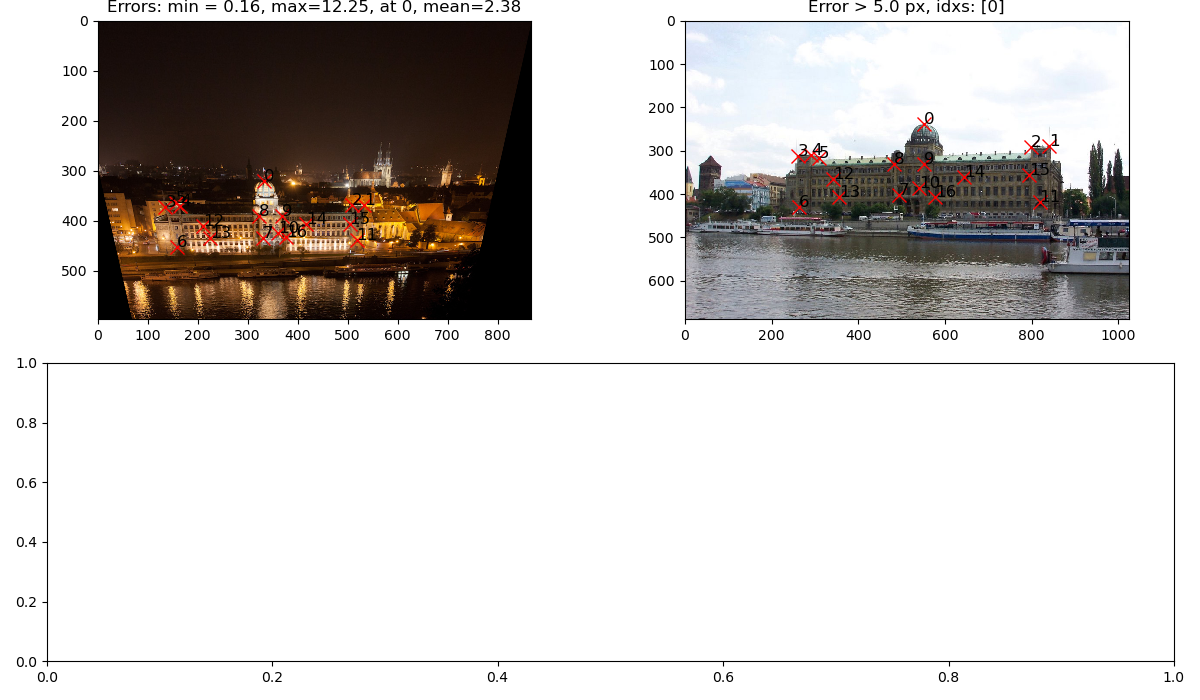

<ipython-input-12-ba3cf61331c2>:115: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  self.vertical_tilt_slider.on_trait_change(self.show_current_pair)
<ipython-input-12-ba3cf61331c2>:116: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  self.horizontal_tilt_slider.on_trait_change(self.show_current_pair)


/Users/oldufo/dev/correspondence_annotator/pixelstitch/imgproc.py:181: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_out = cv2.warpPerspective(img, H,  (new_w, new_h))
/Users/oldufo/dev/correspondence_annotator/pixelstitch/imgproc.py:181: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_out = cv2.warpPerspective(img, H,  (new_w, new_h))
/Users/oldufo/dev/correspondence_annotator/pixelstitch/imgproc.py:181: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_out = cv2.warpPerspective(img, H,  (new_w, new_h))
/Users/oldufo/dev/correspondence_annotator/pixelstitch/imgproc.py:181: De

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
CA.start(figsize=(12,7))